# data

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
import calendar

# =========================
# Settings (2021-01-01 to 2022-06-30)
# =========================
START = "2021-01-01"
END   = "2022-06-30"

# Month starts: 2021-01-01 ... 2022-06-01
date_range = pd.date_range(start=START, end=END, freq="MS")

# Store GPT views
gpt_means, gpt_vars = [], []
dates = []            # month label (YYYY-MM-01)
sp500_tickers = None  # ticker universe (fixed from first month)

def _month_end(dt: pd.Timestamp) -> str:
    last_day = calendar.monthrange(dt.year, dt.month)[1]
    return dt.replace(day=last_day).strftime("%Y-%m-%d")

for current_date in date_range:
    start_date = current_date.strftime("%Y-%m-%d")
    end_date = _month_end(current_date)

    fp = Path(f"responses/gpt_{start_date}_{end_date}.json")
    if not fp.exists():
        raise FileNotFoundError(f"Missing GPT responses file: {fp}")

    gpt_dict = json.load(open(fp, "r"))

    # Fix ticker universe on first month (stable ordering)
    if sp500_tickers is None:
        sp500_tickers = list(gpt_dict.keys())

    means_row, vars_row = [], []
    for t in sp500_tickers:
        vals = (gpt_dict.get(t, {}) or {}).get("expected_return", None)
        if isinstance(vals, list) and len(vals) > 0:
            means_row.append(float(np.mean(vals)))
            vars_row.append(float(np.var(vals)))
        else:
            means_row.append(np.nan)
            vars_row.append(np.nan)

    gpt_means.append(means_row)
    gpt_vars.append(vars_row)
    dates.append(start_date)


In [2]:
# Views (means/vars) as DataFrames: rows=tickers, columns=month-start dates
gpt_means_df = pd.DataFrame(np.array(gpt_means), index=dates, columns=sp500_tickers).T
gpt_vars_df  = pd.DataFrame(np.array(gpt_vars),  index=dates, columns=sp500_tickers).T

gpt_means_df.head()


,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01
AAL,0.088776,0.075914,0.050000,-0.058243,0.051600,-0.065000,-0.015000,0.0476,0.04220,0.024225,0.0214,0.02296,0.0122,-0.01594,-0.02160,-0.0018,-0.0184,-0.0412
PNW,-0.033843,-0.070698,0.163306,0.034154,-0.000827,-0.011000,0.015000,-0.0167,-0.01600,-0.027200,-0.0181,-0.01500,0.0116,0.02000,0.01264,-0.0117,-0.0131,-0.0162
ABT,0.132889,-0.008166,0.000501,0.005758,0.007400,0.005300,0.044400,0.0231,0.01480,0.024200,0.0243,0.03590,0.0130,0.01540,0.01240,0.0144,0.0158,0.0116
AMD,-0.066187,-0.011556,-0.065893,0.039745,0.013800,0.144590,0.114000,0.0336,0.03408,0.046000,0.0814,0.05460,0.0524,0.02760,0.03860,0.0348,0.0588,0.0590
APD,-0.023644,-0.030032,0.081297,0.021152,0.031253,-0.030978,0.011645,0.0105,-0.00014,0.022200,0.0142,0.01694,0.0173,0.02130,0.01930,0.0123,0.0074,0.0143


In [3]:
np.array(gpt_means).shape


(18, 413)

In [4]:
import os
import glob
import pandas as pd

PORT_DIR = "responses_portfolios"

def _find_date_col(df: pd.DataFrame) -> str:
    for c in ["date_key", "Date", "date", "ym"]:
        if c in df.columns:
            return c
    # fallback: first unnamed index column
    if len(df.columns) > 0 and str(df.columns[0]).lower().startswith("unnamed"):
        df = df.rename(columns={df.columns[0]: "date_key"})
        return "date_key"
    raise ValueError(f"Aucune colonne de date trouvée. Colonnes: {list(df.columns)}")

def _read_and_standardize(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    date_col = _find_date_col(df)

    # Standardize to 'date_key' as datetime
    if date_col == "ym":
        # 'YYYY-MM' -> month start
        df["date_key"] = pd.to_datetime(df["ym"].astype(str) + "-01", errors="coerce")
    else:
        df["date_key"] = pd.to_datetime(df[date_col], errors="coerce")

    # drop original date cols (except date_key)
    drop_cols = [c for c in ["Date", "date", "ym"] if c in df.columns and c != "date_key"]
    df = df.drop(columns=drop_cols, errors="ignore")

    # keep only rows with date
    df = df.dropna(subset=["date_key"]).copy()
    return df

def combine_monthly_portfolios(
    pattern: str,
    out_path: str,
) -> pd.DataFrame:
    files = sorted(glob.glob(os.path.join(PORT_DIR, pattern)))
    if not files:
        raise FileNotFoundError(f"Aucun fichier trouvé avec le pattern: {PORT_DIR}/{pattern}")

    dfs = []
    for f in files:
        df = _read_and_standardize(f)
        df["source_file"] = os.path.basename(f)  # pratique pour debug
        dfs.append(df)

    out = pd.concat(dfs, ignore_index=True)

    # sort & drop duplicates by date (keep last)
    out = out.sort_values("date_key")
    out = out.drop_duplicates(subset=["date_key"], keep="last").reset_index(drop=True)

    # save combined
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    out.to_csv(out_path, index=False)
    return out

# ---- Build combined baseline files ----
eq_combined = combine_monthly_portfolios(
    pattern="equal_weighted_portfolio*.csv",
    out_path=os.path.join(PORT_DIR, "equal_weighted_portfolio.csv"),
)

opt_combined = combine_monthly_portfolios(
    pattern="optimized_portfolio*.csv",
    out_path=os.path.join(PORT_DIR, "optimized_portfolio.csv"),
)

print("Baselines combinés :")
print(" -", os.path.join(PORT_DIR, "equal_weighted_portfolio.csv"), "(", len(eq_combined), "rows )")
print(" -", os.path.join(PORT_DIR, "optimized_portfolio.csv"), "(", len(opt_combined), "rows )")
display(eq_combined.head())
display(opt_combined.head())


Baselines combinés :
 - responses_portfolios\equal_weighted_portfolio.csv ( 35 rows )
 - responses_portfolios\optimized_portfolio.csv ( 35 rows )


,Portfolio_Return,date_key,source_file
0,0.061814,2021-02-01,equal_weighted_portfolio_2021-01-01_2021-01-31...
1,0.058395,2021-03-01,equal_weighted_portfolio_2021-02-01_2021-02-28...
2,0.055666,2021-03-31,equal_weighted_portfolio.csv
3,0.046023,2021-04-01,equal_weighted_portfolio_2021-03-01_2021-03-31...
4,0.046226,2021-04-30,equal_weighted_portfolio.csv


,Portfolio_Return,date_key,source_file
0,0.061814,2021-02-01,optimized_portfolio_2021-01-01_2021-01-31.csv
1,0.058395,2021-03-01,optimized_portfolio_2021-02-01_2021-02-28.csv
2,-0.156229,2021-03-31,optimized_portfolio.csv
3,0.046023,2021-04-01,optimized_portfolio_2021-03-01_2021-03-31.csv
4,0.124080,2021-04-30,optimized_portfolio.csv


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

"""
Baselines portfolio returns (generated by baselines.py)
Expected files:
  - responses_portfolios/equal_weighted_portfolio.csv
  - responses_portfolios/optimized_portfolio.csv
"""
equal_weighted_portfolio_returns = pd.read_csv('responses_portfolios/equal_weighted_portfolio.csv')
optimized_portfolio_returns      = pd.read_csv('responses_portfolios/optimized_portfolio.csv')

equal_weighted_portfolio_returns.head()


,Portfolio_Return,date_key,source_file
0,0.061814,2021-02-01,equal_weighted_portfolio_2021-01-01_2021-01-31...
1,0.058395,2021-03-01,equal_weighted_portfolio_2021-02-01_2021-02-28...
2,0.055666,2021-03-31,equal_weighted_portfolio.csv
3,0.046023,2021-04-01,equal_weighted_portfolio_2021-03-01_2021-03-31...
4,0.046226,2021-04-30,equal_weighted_portfolio.csv


In [6]:
"""
GPT monthly portfolio weights (Black-Litterman output from evaluate_multiple_updated.py)
"""
import pandas as pd
import numpy as np

tau = 0.025

weights_path = f"results/gpt_black_litterman_weights_tau_{tau}.csv"
gpt_weights_df = pd.read_csv(weights_path)

# detect date column
if "Date" in gpt_weights_df.columns:
    date_col = "Date"
elif "date_key" in gpt_weights_df.columns:
    date_col = "date_key"
else:
    date_col = gpt_weights_df.columns[0]

gpt_weights_df[date_col] = pd.to_datetime(gpt_weights_df[date_col], errors="coerce")
gpt_weights_df = gpt_weights_df.dropna(subset=[date_col]).set_index(date_col).sort_index()

# transpose for plotting: rows=tickers, columns=dates
gpt_results = gpt_weights_df.T
gpt_results.head()


Date,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01
A,0.000000e+00,3.870470e-17,0.000000e+00,0.000000e+00,0.000000e+00,5.157648e-17,0.000000e+00,5.446799e-17,4.813262e-17,1.631332e-17,4.361647e-17,3.736986e-18,1.294970e-16,0.000000e+00,0.0,0.000000e+00,4.060510e-17,2.071622e-17
AAL,0.000000e+00,0.000000e+00,1.602857e-17,0.000000e+00,3.078064e-17,2.583224e-16,0.000000e+00,1.083805e-16,1.411588e-15,8.822152e-19,6.554965e-17,1.780318e-16,2.143155e-17,0.000000e+00,0.0,0.000000e+00,0.000000e+00,5.234720e-17
AAP,0.000000e+00,5.823118e-17,6.048614e-17,0.000000e+00,6.339361e-17,0.000000e+00,1.192148e-16,7.218572e-17,5.356550e-16,2.348312e-17,0.000000e+00,0.000000e+00,2.405214e-17,0.000000e+00,0.0,6.653298e-14,0.000000e+00,2.142293e-17
AAPL,3.034681e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.246046e-17,2.245890e-17,1.303112e-17,0.000000e+00,4.072401e-17,5.881836e-17,2.418837e-17,0.000000e+00,2.666996e-16,0.0,0.000000e+00,0.000000e+00,0.000000e+00
ABBV,0.000000e+00,1.435163e-17,5.991520e-17,3.181897e-17,2.127580e-16,0.000000e+00,8.979837e-19,0.000000e+00,0.000000e+00,7.737021e-17,3.997849e-17,2.306852e-17,5.888239e-18,3.110912e-17,0.0,0.000000e+00,1.808156e-17,0.000000e+00


In [7]:
"""
Gemma3 1B monthly portfolio weights (Black-Litterman output from evaluate_multiple.py)
"""
import pandas as pd
import numpy as np

tau = 0.025

weights_path = f"results/gemma3_1b_black_litterman_weights_tau_{tau}.csv"
gemma_weights_df = pd.read_csv(weights_path)

# detect date column
if "Date" in gemma_weights_df.columns:
    date_col = "Date"
elif "date_key" in gemma_weights_df.columns:
    date_col = "date_key"
else:
    date_col = gemma_weights_df.columns[0]

gemma_weights_df[date_col] = pd.to_datetime(gemma_weights_df[date_col], errors="coerce")
gemma_weights_df = gemma_weights_df.dropna(subset=[date_col]).set_index(date_col).sort_index()

# transpose for plotting: rows=tickers, columns=dates
gemma_results = gemma_weights_df.T
gemma_results.head()


Date,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01
A,5.979781e-17,0.000000e+00,1.275519e-17,1.837214e-16,2.248594e-16,1.111741e-16,0.000000e+00,0.000000e+00,1.636985e-16,2.368162e-17,3.545913e-16,3.089197e-16,7.940221e-17,2.448097e-16,0.000000e+00,5.258051e-17,0.000000e+00,4.484337e-17
AAL,0.000000e+00,1.343081e-16,2.583608e-17,2.073561e-16,6.455132e-17,0.000000e+00,8.578832e-17,3.155225e-15,1.184477e-15,0.000000e+00,0.000000e+00,5.861957e-16,1.481786e-16,1.329040e-16,1.191655e-15,6.720799e-17,0.000000e+00,0.000000e+00
AAP,1.803784e-16,0.000000e+00,0.000000e+00,0.000000e+00,1.168763e-16,8.835981e-17,0.000000e+00,0.000000e+00,1.530149e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.405046e-15,0.000000e+00,0.000000e+00,0.000000e+00
AAPL,3.349378e-17,4.000652e-17,7.465898e-17,0.000000e+00,0.000000e+00,0.000000e+00,7.614660e-17,5.096038e-16,0.000000e+00,5.472743e-17,0.000000e+00,0.000000e+00,3.190322e-17,4.943943e-17,0.000000e+00,1.014246e-17,0.000000e+00,0.000000e+00
ABBV,9.603432e-17,2.006179e-17,5.479188e-17,0.000000e+00,0.000000e+00,6.612364e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.189236e-15,0.000000e+00,0.000000e+00,0.000000e+00,3.635553e-17,1.075183e-16,8.484140e-17


In [8]:
# """
# Market caps snapshot (mc) from filtered_sp500_data.csv
# => uses the LAST available non-null market_equity per ticker up to period_end (inclusive)
# """
# import pandas as pd
# import numpy as np

# filtered_path = "yfinance/filtered_sp500_data.csv"   # ajuste si besoin
# sp = pd.read_csv(filtered_path, low_memory=False)

# # Parse date (YYYYMMDD) -> datetime
# sp["date_key"] = pd.to_datetime(
#     sp["date"].astype("Int64").astype(str),
#     format="%Y%m%d",
#     errors="coerce"
# )

# # Normalize tickers
# sp["tic"] = (
#     sp["tic"].astype(str).str.strip().str.upper().str.replace("-", ".", regex=False)
# )

# # Ensure numeric market_equity
# sp["market_equity"] = pd.to_numeric(sp["market_equity"], errors="coerce")

# # ---- choose your snapshot date (end of your analysis window, or end of a month) ----
# # Example: to build caps for a given month end:
# # period_end = pd.Timestamp("2021-01-31")
# # If you already have an 'end_date' variable elsewhere, reuse it:
# period_end = pd.Timestamp("2022-06-30")  # <-- change as needed

# # Keep rows up to period_end, drop null caps, take last per ticker
# tmp = sp.loc[sp["date_key"].notna() & (sp["date_key"] <= period_end)].copy()
# tmp = tmp.dropna(subset=["market_equity"])

# market_caps_df = (
#     tmp.sort_values(["tic", "date_key"])
#        .groupby("tic", as_index=False)
#        .tail(1)[["tic", "market_equity", "date_key"]]
#        .rename(columns={"market_equity": "mc", "date_key": "mc_date"})
#        .reset_index(drop=True)
# )

# print("market_caps_df rows:", len(market_caps_df))
# market_caps_df.head()


In [9]:
"""
GPT portfolio returns (generated by calculate_llm_returns.py)
"""
import glob
import pandas as pd

tau = 0.025

# Match: results/gpt_black_litterman_returns_tau_0.025_2021-01-01_2022-06-30.csv
pattern1 = f"results/gpt_black_litterman_returns_tau_{tau}_*.csv"
pattern2 = f"results/gpt_black_litterman_returns_tau_{tau}.csv"

candidates = sorted(glob.glob(pattern1))
if not candidates:
    candidates = sorted(glob.glob(pattern2))

if not candidates:
    raise FileNotFoundError(
        f"Could not find GPT returns CSV in results/. Tried patterns:\n- {pattern1}\n- {pattern2}\n"
        "Run calculate_llm_returns.py first."
    )

gpt_returns_path = candidates[-1]
print("Using:", gpt_returns_path)
gpt_returns = pd.read_csv(gpt_returns_path)
gpt_returns.head()


Using: results\gpt_black_litterman_returns_tau_0.025_2021-01-01_2022-06-30.csv


,date_key,Portfolio_Return
0,2021-02-01,0.093270
1,2021-03-01,0.065488
2,2021-04-01,0.042531
3,2021-05-01,0.064012
4,2021-06-01,0.035858


In [10]:
"""
Gemma3 1B portfolio returns (generated by calculate_llm_returns.py)
"""
import glob
import pandas as pd

tau = 0.025

candidates = sorted(glob.glob(f"results/gemma3_1b_black_litterman_returns_tau_{tau}_*.csv"))
if not candidates:
    candidates = sorted(glob.glob(f"results/gemma3_1b_black_litterman_returns_tau_{tau}.csv"))

if not candidates:
    raise FileNotFoundError("Could not find Gemma3_1b returns CSV in results/. Run calculate_llm_returns.py first.")

gemma_returns_path = candidates[-1]
print("Using:", gemma_returns_path)
gemma_returns = pd.read_csv(gemma_returns_path)
gemma_returns.head()


Using: results\gemma3_1b_black_litterman_returns_tau_0.025_2021-01-01_2022-06-30.csv


,date_key,Portfolio_Return
0,2021-02-01,0.085453
1,2021-03-01,0.034360
2,2021-04-01,0.009096
3,2021-05-01,0.021977
4,2021-06-01,-0.003991


In [11]:
"""
S&P 500 proxy returns (monthly) from yfinance ETF (e.g., SPY):
- Download daily adjusted prices
- Convert to monthly returns (month-end to month-end)
- Keep Jan..Jun 2021 inclusive
"""
import pandas as pd

try:
    import yfinance as yf
except ImportError:
    raise ImportError("yfinance n'est pas installé. Fais: pip install yfinance")

ETF = "SPY"  # alternatives: "IVV", "VOO"
start = "2021-01-01"
end   = "2022-06-30"

px = yf.download(ETF, start=start, end=end, progress=False)
if px.empty:
    raise ValueError(f"No data downloaded for {ETF}. Check internet access / ticker.")

# Prefer Adj Close if available, else Close
if "Adj Close" in px.columns:
    close = px["Adj Close"]
else:
    close = px["Close"]

# If DataFrame (edge case), take first column
if isinstance(close, pd.DataFrame):
    close = close.iloc[:, 0]

close = close.dropna()

# Month-end close and monthly returns
m_close = close.resample("ME").last()
m_ret = m_close.pct_change().dropna()

sp500_proxy = pd.DataFrame({
    "date_key": m_ret.index,
    "Portfolio_Return": m_ret.values
})

# Keep months end Jan..Jun 2022
sp500_proxy = sp500_proxy[(sp500_proxy["date_key"] >= "2021-01-31") & (sp500_proxy["date_key"] <= "2022-06-30")].copy()
sp500_proxy


C:\Users\alexi\AppData\Local\Temp\ipykernel_30864\2484302714.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(ETF, start=start, end=end, progress=False)


,date_key,Portfolio_Return
0,2021-02-28,0.027805
1,2021-03-31,0.045400
2,2021-04-30,0.052910
3,2021-05-31,0.006566
4,2021-06-30,0.022428
5,2021-07-31,0.024412
6,2021-08-31,0.029760
7,2021-09-30,-0.046605
8,2021-10-31,0.070164
9,2021-11-30,-0.008035


# evlauate

In [12]:
# sp500_returns
# equal_weighted_portfolio_returns
# optimized_portfolio_returns
# gpt_returns

In [13]:
import numpy as np
import pandas as pd

def _standardize_returns(df: pd.DataFrame, name: str) -> pd.Series:
    """
    Accepts df with 'Portfolio_Return' and one date column among: date_key / Date / ym.
    Returns a Series indexed by datetime at MONTH START (YYYY-MM-01).
    """
    df = df.copy()

    # Detect date column
    if "date_key" in df.columns:
        dt = pd.to_datetime(df["date_key"], errors="coerce")
    elif "Date" in df.columns:
        dt = pd.to_datetime(df["Date"], errors="coerce")
    elif "ym" in df.columns:
        dt = pd.to_datetime(df["ym"].astype(str) + "-01", errors="coerce")
    else:
        raise ValueError(f"{name}: could not find a date column in {list(df.columns)}")

    if "Portfolio_Return" not in df.columns:
        raise ValueError(f"{name}: missing 'Portfolio_Return' column")

    s = pd.Series(pd.to_numeric(df["Portfolio_Return"], errors="coerce").values, index=dt)
    s = s.dropna()

    # Normalize to month start
    s.index = s.index.to_period("M").to_timestamp()

    # Deduplicate and sort
    s = s[~s.index.duplicated(keep="last")].sort_index()
    return s

def _infer_periods_per_year(index: pd.DatetimeIndex) -> int:
    # For monthly series
    return 12

# Build return series
r_sp500 = _standardize_returns(sp500_proxy, "SP500 proxy")
r_ew    = _standardize_returns(equal_weighted_portfolio_returns, "EW")
r_mvo   = _standardize_returns(optimized_portfolio_returns, "MVO")
r_gpt   = _standardize_returns(gpt_returns, "BLM-GPT")
r_gemma = _standardize_returns(gemma_returns, "BLM-Gemma3_1b")

# Align by common dates
common_idx = r_sp500.index.intersection(r_ew.index).intersection(r_mvo.index).intersection(r_gpt.index).intersection(r_gemma.index)

r_sp500 = r_sp500.loc[common_idx]
r_ew    = r_ew.loc[common_idx]
r_mvo   = r_mvo.loc[common_idx]
r_gpt   = r_gpt.loc[common_idx]
r_gemma = r_gemma.loc[common_idx]

portfolios = {
    "SP500": r_sp500,
    "EW": r_ew,
    "MVO": r_mvo,
    "BLM-GPT": r_gpt,
    "BLM-Gemma3_1b": r_gemma,
}

ppy = _infer_periods_per_year(common_idx)
rf = 0.02 / ppy  # per-period risk-free rate (2% annual)

stats = {}
for name, returns in portfolios.items():
    returns = returns.astype(float)
    cum = (1 + returns).prod() - 1
    ann_ret = (1 + cum) ** (ppy / max(1, len(returns))) - 1
    ann_vol = returns.std(ddof=1) * np.sqrt(ppy)
    sharpe = ((returns.mean() - rf) / returns.std(ddof=1)) * np.sqrt(ppy) if returns.std(ddof=1) > 0 else np.nan

    wealth = (1 + returns).cumprod()
    peak = wealth.cummax()
    dd = wealth / peak - 1
    mdd = dd.min()

    stats[name] = {
        "Cum. Return": round(float(cum), 4),
        "Ann. Return": round(float(ann_ret), 4),
        "Ann. Vol": round(float(ann_vol), 4),
        "Sharpe": round(float(sharpe), 4),
        "Max Drawdown": round(float(mdd), 4),
    }

stats_df = pd.DataFrame(stats).T
print(f"Periods/year inferred: {ppy}")
stats_df


Periods/year inferred: 12


,Cum. Return,Ann. Return,Ann. Vol,Sharpe,Max Drawdown
SP500,0.0492,0.0345,0.1622,0.1636,-0.1933
EW,0.0611,0.0428,0.1600,0.2133,-0.1577
MVO,0.0993,0.0691,0.3639,0.3048,-0.2563
BLM-GPT,0.6556,0.4274,0.1606,2.1997,-0.0764
BLM-Gemma3_1b,-0.5069,-0.3929,0.3950,-1.0786,-0.5741


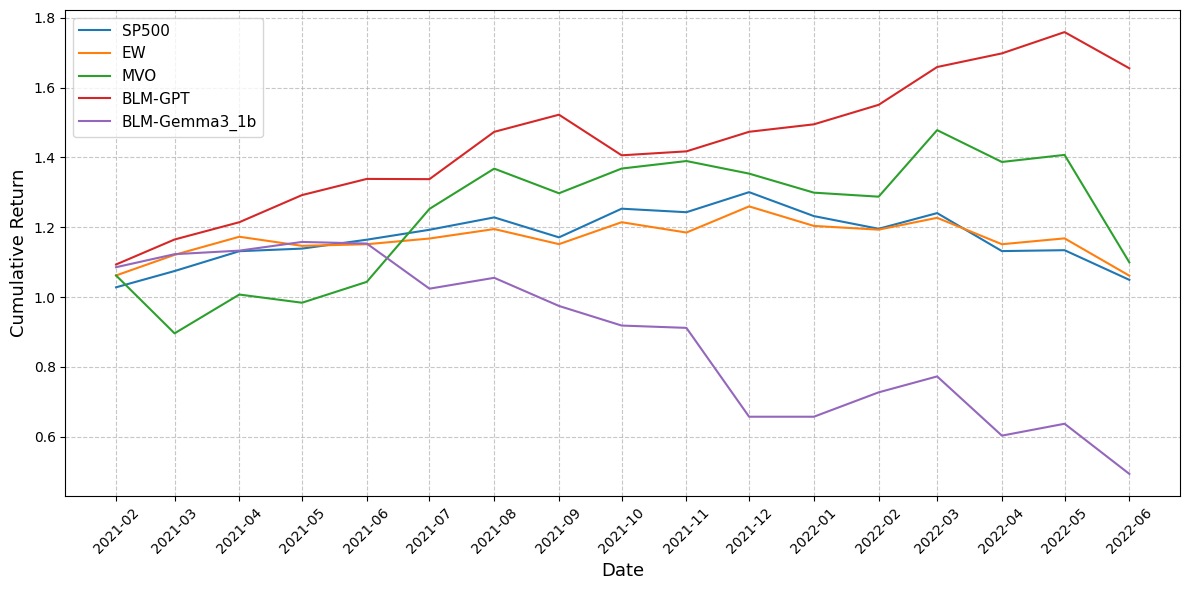

In [14]:
import matplotlib.pyplot as plt
import matplotlib

plt.figure(figsize=(12, 6))

for name, returns in portfolios.items():
    cum = (1 + returns).cumprod()
    plt.plot(cum.index, cum.values, label=name)

plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Date", fontsize=13)
plt.ylabel("Cumulative Return", fontsize=13)
plt.legend(loc="upper left", fontsize=11)

plt.gca().xaxis.set_major_locator(matplotlib.dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
